In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! pip install Ninja
! git clone https://github.com/NVlabs/stylegan3.git

import os
os.chdir("/content/stylegan3")

import click
import dnnlib
import h5py
import torch
import numpy as np
from PIL import Image
from gen_images import make_transform
from scipy import sparse, stats
from scipy.stats import t, zscore
from scipy.ndimage import interpolation
from sklearn.linear_model import LinearRegression
import legacy
import matplotlib.pyplot as plt


device = torch.device('cuda')
network_pkl = "/content/drive/My Drive/PhD/GANs/StyleGAN3/stylegan3-r-ffhq-1024x1024.pkl"
with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore
label = torch.zeros([1, G.c_dim], device=device)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'stylegan3' already exists and is not an empty directory.


In [3]:
def reconstruction(latents):
    latents = torch.from_numpy(np.repeat(latents, 16, axis=0).transpose(1, 0, 2)).to(device)
    for i in range(len(latents)):
        img = G.synthesis(latents[None, i], noise_mode="none")
        img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
        img = Image.fromarray(img[0].cpu().numpy(), 'RGB')
        return img

In [4]:
f1 = h5py.File("/content/drive/My Drive/faces/GANs_StyleGAN3_normMUA.mat", "r")

# delete broken microelectrode array
x_te = np.delete(np.array(f1["test_MUA"]), np.arange(320, 384), axis=1)
x_tr = np.delete(np.array(f1["train_MUA"]), np.arange(320, 384), axis=1)
w_te = np.load("/content/drive/My Drive/faces/w_te.npy")[:, 0]
w_tr = np.load("/content/drive/My Drive/faces/w_tr.npy")[:, 0]
reg = LinearRegression().fit(x_tr, w_tr)
y_te = reg.predict(x_te)

Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


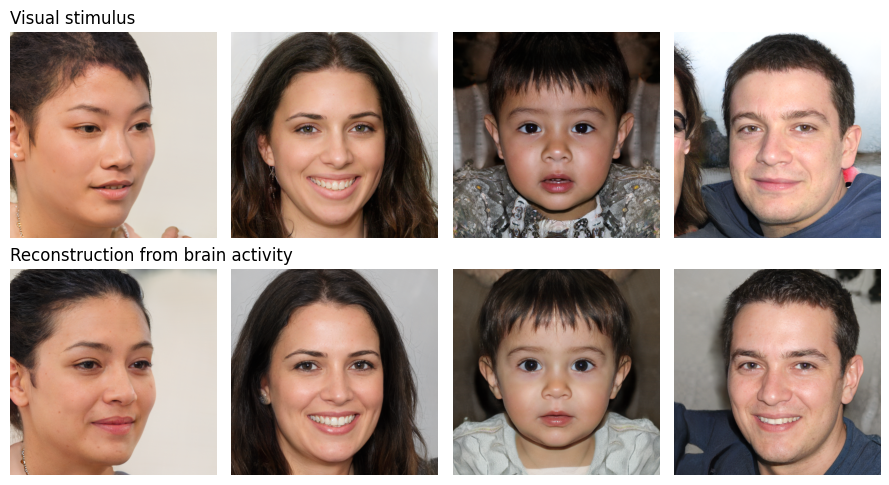

In [5]:
fig, axs = plt.subplots(2, 4, figsize=(9, 5))
for i, index in enumerate([92, 17, 37, 0]):
    axs[0, i].imshow(reconstruction(w_te[index, None, None]))
    axs[0, i].axis("off")
    axs[0, 0].set_title("Visual stimulus", loc="left")
    axs[1, i].imshow(reconstruction(y_te[index, None, None]))
    axs[1, i].axis("off")
    axs[1, 0].set_title("Reconstruction from brain activity", loc="left")
plt.tight_layout()
plt.show()